# Financial Cliff Walking

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [132]:
N_states = 4
N_time = 12

gamma=1

epsilon = 0.1 # probability for exploration.
alpha = 0.001 # Step size

action_up = 1
action_down = 2
action_zero = 0
actions = [action_up, action_down, action_zero]

start = [0, 0]
goal = [0, N_time-1]

In [186]:
def step(state, action):
    i, j = state
    
    if action == action_up:
        next_state = [min(i+1,N_states-1),min(j+1,N_time-1)]
    elif action == action_down:
        next_state = [max(i-1,0),min(j+1,N_time-1)]
    elif action == action_zero:
        next_state = [i,min(j+1,N_time-1)]
    else:
        raise ValueError("action not valid")
    reward = -1
    
    if action == action_zero:
        reward = 0
        
    if ((action == action_down and i==1 and 1 <= j < N_time-2) or
        (action == action_zero and state == start) or(
           action == action_down and state == start)) or (
        i==0 and 1<=j<=N_time-2):
        reward=-100
    
    if (next_state[1] == N_time - 1):
        if (next_state[0] ==0):
            reward = 10
        else:
            reward = -10
    return next_state, reward

In [155]:
print(step([0, 0], action_up))
print(step([2, 3], action_down))
print(step([1, 5], action_down))

([1, 1], -1)
([1, 4], -1)
([0, 6], -100)


In [187]:
def choose_action(state, q_value, eps=epsilon):
    if np.random.binomial(1,eps) == 1:
        action = np.random.choice(actions)
    else:
        values_ = q_value[state[0],state[1],:]
        action = np.random.choice(
            [action_ for action_, value_ in enumerate(values_)
             if value_ == np.max(values_)]
        )
    if state[0] == 0 and state[1]>0:
        action = action_zero
    return action

In [190]:
# If q_value contains only zeroes, the action is always random
q_value = np.zeros((N_states, N_time, len(actions)))
print(choose_action([0, 0], q_value, epsilon))

0


In [214]:
state=start
q_sarsa_mat = np.zeros((N_states, N_time, len(actions)))
action=choose_action(state, q_sarsa_mat,epsilon)
step(state,action)

([1, 1], -1)

In [215]:
def sarsa(q_value,expected=False,step_size=alpha,eps=epsilon):
    state = start
    action = choose_action(state, q_value,eps)
    rewards = 0.0
    
    while (state[1] != N_time-1) and not (1 <= state[1] <= N_time-2 and state[0]==0):
        next_state, reward = step(state,action)
        next_action = choose_action(next_state,q_value,eps)
        rewards += reward
        if not expected:
            target = q_value[next_state[0],next_state[1],next_action]
        else:
            target = 0.0
            q_next = q_value[next_state[0],next_state[1],:]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in actions:
                if action_ in best_actions:
                    target += ((1.0-eps)/len(best_actions)
                               + eps/len(actions))*q_value[next_state[0],next_state[1],action_]
                else:
                    target += eps/len(actions)*q_value[next_state[0],next_state[1],action_]
        target *= gamma
        q_value[state[0],state[1],action] += step_size*(
                reward + target - q_value[state[0],state[1],action])
        state = next_state
        action = next_action
    return rewards

In [223]:
def q_learning(q_value, step_size=alpha, eps=epsilon):
    state = start
    rewards = 0.0
    while state[1] != N_time -1 and not (1<=state[1]<=N_time-2 and state[0]==0):
        action = choose_action(state, q_value, eps)
        next_state, reward = step(state,action)
        rewards += reward
        q_value[state[0],state[1],action] += step_size*(
            reward + gamma*np.max(q_value[next_state[0],next_state[1],:])-q_value[state[0],state[1],action])
        state = next_state
    return rewards

In [229]:
def figure_cliff_walking():
    # Number of episodes in each run
    episodes = 2500
    EPOCH = 40

    # Perform 100 independent runs
    runs = 500
    
    # Initialise the rewards arrays
    rewards_sarsa = np.zeros(episodes)
    rewards_q_learning = np.zeros(episodes)
    for r in tqdm(range(runs)):
        # Initialise the action value arrays 
        q_sarsa_mat = np.zeros((N_states, N_time, len(actions)))
        q_learning_mat = np.zeros((N_states, N_time, len(actions)))
        
        # Update the rewards and action value arrays for each episode
        for i in range(0, episodes):
            
            #print(f'run: {r}, episode: {i}')
            
            # The value of epsilon is decremented exponentially
            # after every EPOCH episodes
            eps = epsilon*((1-epsilon)**(i//EPOCH))
            rewards_sarsa[i] += sarsa(q_sarsa_mat, eps=eps)
            rewards_q_learning[i] += q_learning(q_learning_mat, eps=eps)

    # Averaging over independent runs
    rewards_sarsa /= runs
    rewards_q_learning /= runs

    # Draw reward curves
    plt.figure(figsize=(15,7))
    plt.plot(rewards_sarsa, label='Sarsa')
    plt.plot(rewards_q_learning, label='Q-Learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.ylim([-100, 20])
    plt.legend()

    return q_sarsa_mat, q_learning_mat

100%|█████████████████████████████████████████| 500/500 [16:37<00:00,  1.99s/it]


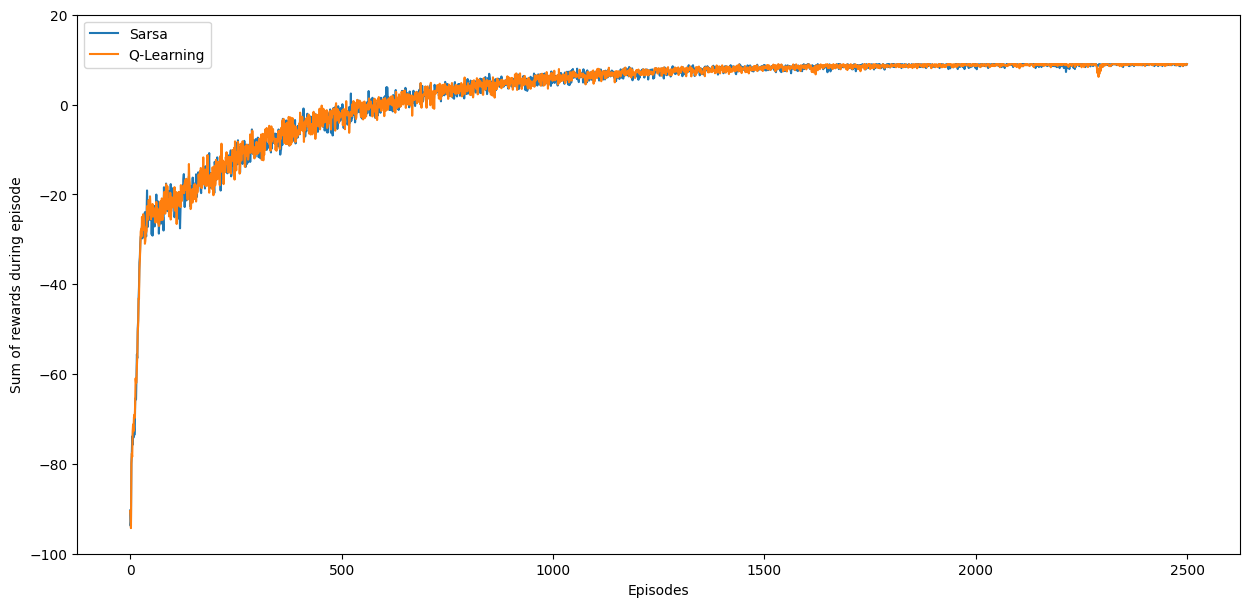

In [230]:
q_sarsa_mat, q_learning_mat = figure_cliff_walking()

In [231]:
def print_optimal_policy(q_value):
    optimal_policy = []
    for i in range(N_states-1, -1, -1):
        optimal_policy.append([])
        for j in range(0, N_time):
            if [i, j] == goal:
                optimal_policy[-1].append('G')
                continue
            bestAction = np.argmax(q_value[i, j, :])
            
            # Action in bankrupt state has been set as Z
            if i == 0 and j > 0 and j < N_time-1:
                optimal_policy[-1].append('Z')
            elif bestAction == action_up:
                # When i = WORLDHEIGHT - 1, U and Z are identical, so we will use Z
                if i == N_states-1:
                    optimal_policy[-1].append('Z')
                else:
                    optimal_policy[-1].append('U')
            elif bestAction == action_down:
                optimal_policy[-1].append('D')
            elif bestAction == action_zero:
                optimal_policy[-1].append('Z')
    
    for row in optimal_policy:
        print(row)

In [232]:
print('Sarsa Optimal Policy:')
print_optimal_policy(q_sarsa_mat)
print('Q-Learning Optimal Policy:')
print_optimal_policy(q_learning_mat)

Sarsa Optimal Policy:
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'U', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z']
['U', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'G']
Q-Learning Optimal Policy:
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z']
['U', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'G']
